<a href="https://colab.research.google.com/github/Qibal2407/UTS-Robotic/blob/main/source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corellation heatmap

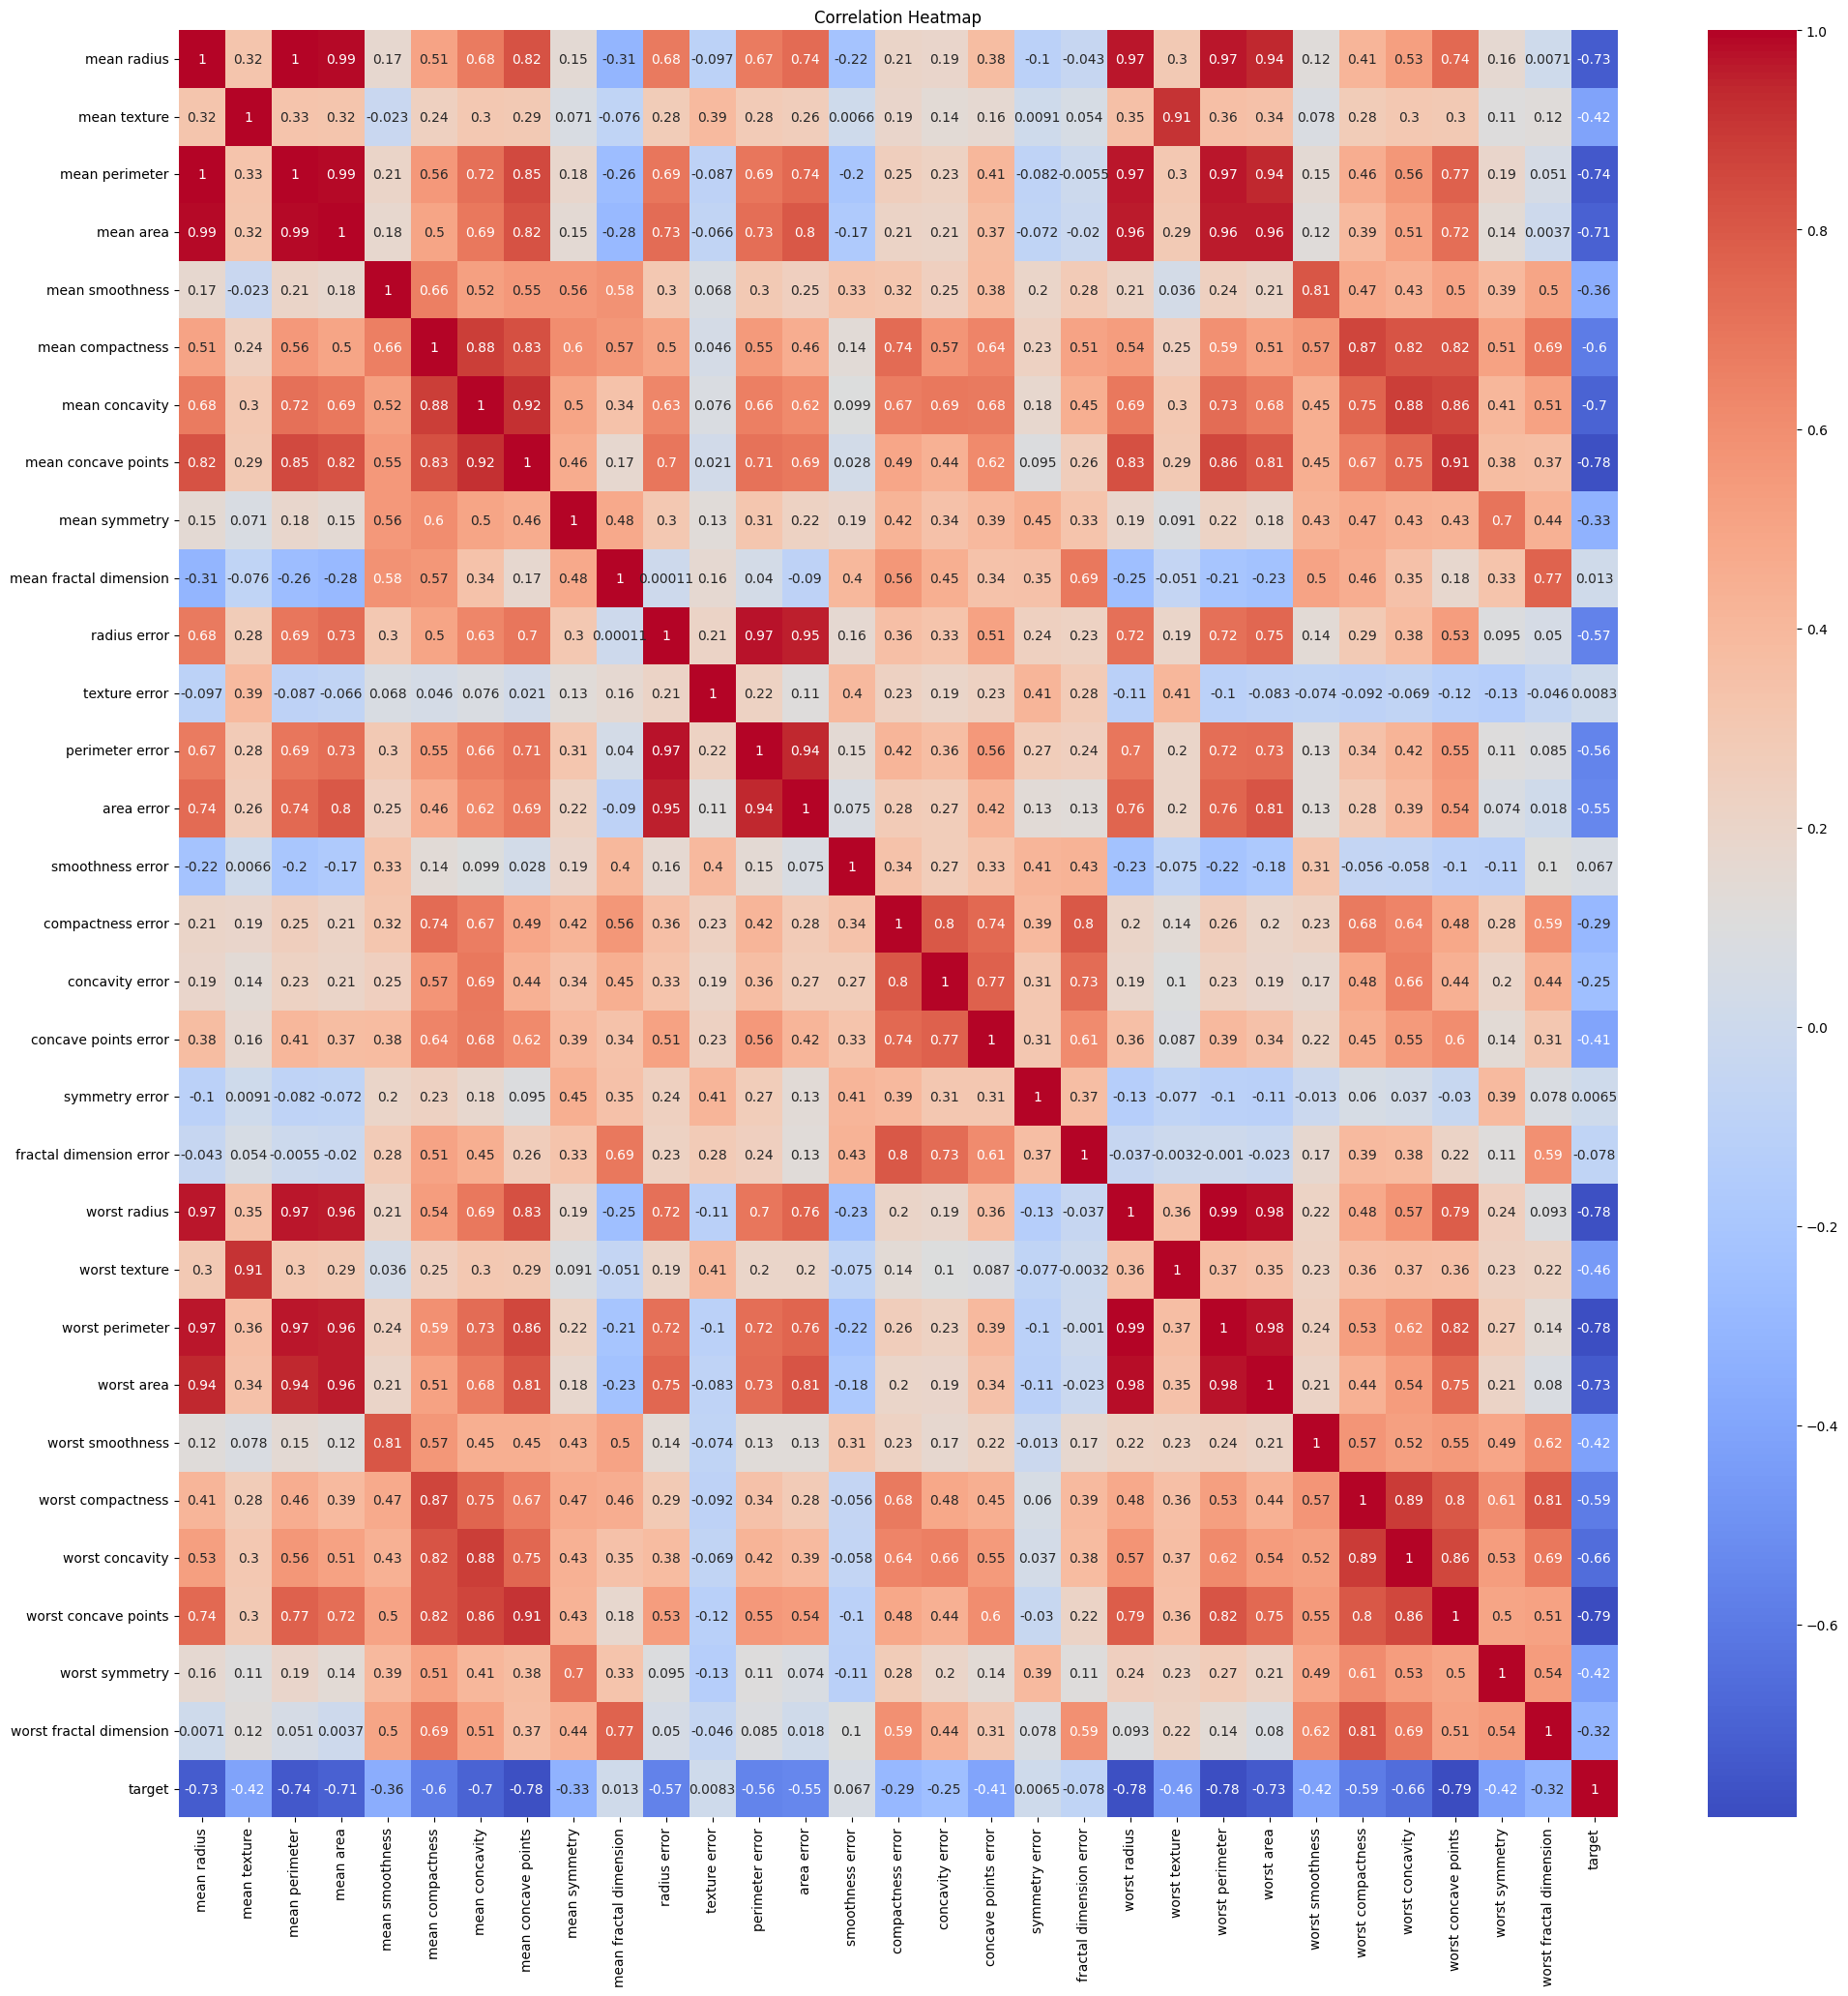

In [4]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_breast_cancer

cancer_dataset = load_breast_cancer()
cancer_df = pd.DataFrame(cancer_dataset.data, columns=cancer_dataset.feature_names)
cancer_df['target'] = cancer_dataset.target
corr_matrix = cancer_df.corr(method='pearson')

# Create a heatmap using the correlation matrix
plt.figure(figsize=(24,24))
plt.title('Correlation Heatmap')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()


# Decision tree

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3272984419327777


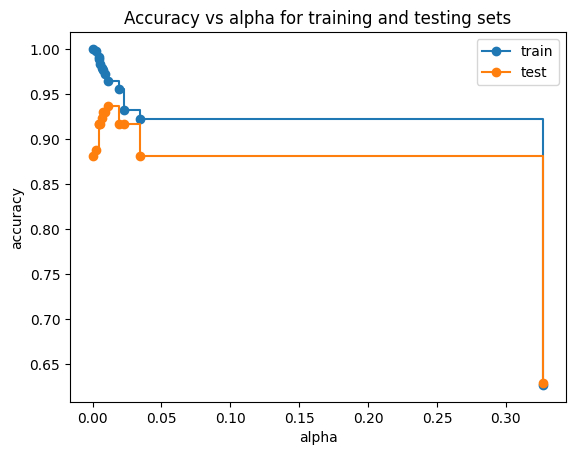

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Random Forest

Accuracy on test data: 0.97


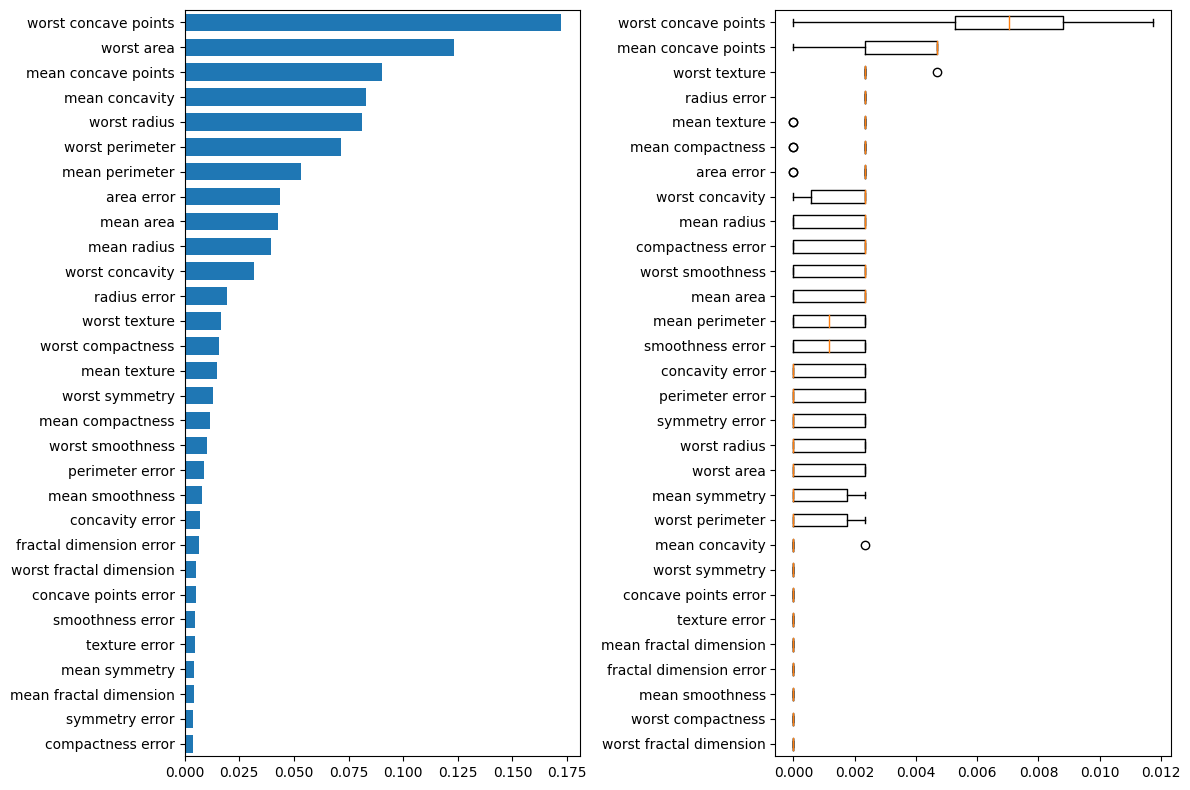

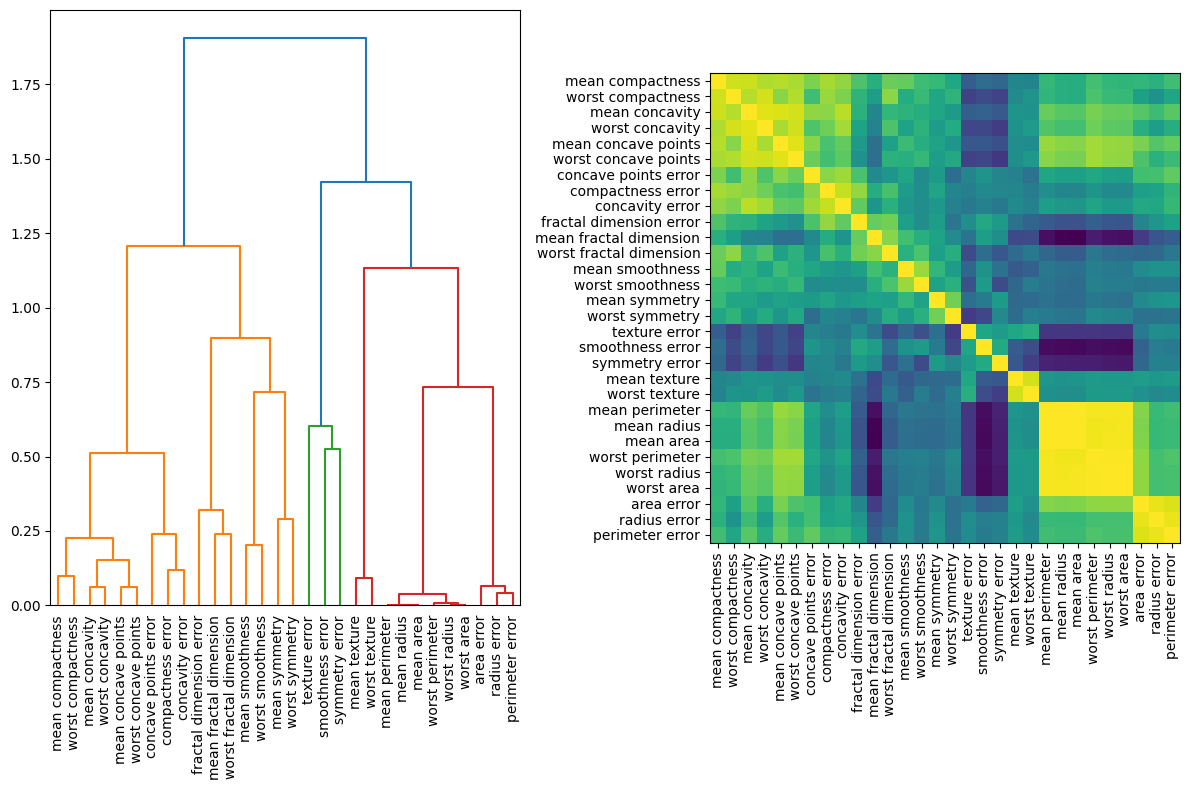

Accuracy on test data with features removed: 0.97


In [16]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

# Self Training

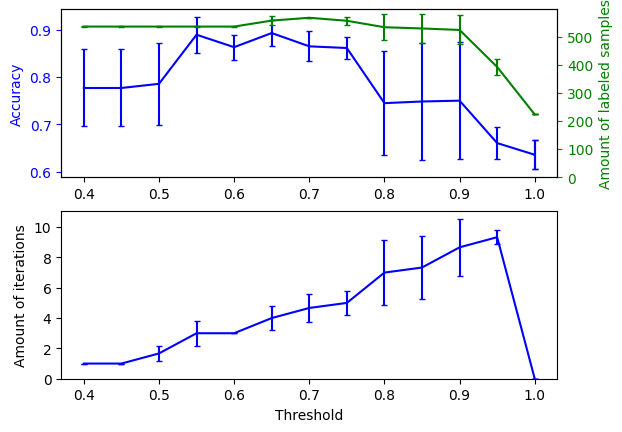

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # We need manual cross validation so that we don't treat -1 as a separate
    # class when computing accuracy
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # The amount of labeled samples that at the end of fitting
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()